In [1]:
import torch
from torch import nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import numpy as np
SEED=0

# T1
# 准备数据

In [2]:
iris=datasets.load_iris()
# list(iris.keys())
X=iris['data']
y=iris['target']
class_idx =[np.where(y==i)[0] for i in range(3)]
tmp=[train_test_split(X[class_idx[i]],y[class_idx[i]],train_size=0.6,test_size=0.4,random_state=SEED) for i in range(3)]
X_train,X_test,y_train,y_test=tmp[0]
for i in range(1,3):
    X_train=np.vstack((X_train,tmp[i][0]))
    X_test=np.vstack((X_test,tmp[i][1]))
    y_train=np.vstack((y_train,tmp[i][2]))
    y_test=np.vstack((y_test,tmp[i][3]))
y_train=y_train.flatten()
y_test=y_test.flatten()
# y_train=y_train.reshape((y_train.shape[0],1))
# y_test=y_test.reshape((y_test.shape[0],1))

# 感知器OvO
## 划分数据集

In [3]:
# 注意要把y的标签换成对应的+1,-1, 而不是原来的那种label形式
X_subset0=np.vstack((X_train[y_train==0],X_train[y_train==1])) #(0,1)
y_subset0=np.hstack(([-1]*len(y_train[y_train==0]),[1]*len(y_train[y_train==1])))
X_subset1=np.vstack((X_train[y_train==0],X_train[y_train==2])) #(0,2)
y_subset1=np.hstack(([-1]*len(y_train[y_train==0]),[1]*len(y_train[y_train==2])))
X_subset2=np.vstack((X_train[y_train==1],X_train[y_train==2])) #(1,2)
y_subset2=np.hstack(([-1]*len(y_train[y_train==1]),[1]*len(y_train[y_train==2])))

## pla from L2

In [4]:
def PLA(data,w_init, max_iter,if_draw=False):
    w = w_init
    X=data[0]
    y=data[1]
    X=np.hstack((np.ones((X.shape[0],1)),X))

    for i in range(max_iter):
        h = np.sign(X @ w)
        mistake_indices = np.where(h != y)[0]
        if len(mistake_indices):
            j = np.random.choice(mistake_indices)
            w = w + y[j]*X[j,:]
        else:
            break

    print('PLA Training Accuracy:',str((X.shape[0]-len(mistake_indices))/X.shape[0]))
    return w

## train and classify

In [5]:
perceptron0=PLA((X_subset0,y_subset0),[0,0,0,0,0],500)
perceptron1=PLA((X_subset1,y_subset1),[0,0,0,0,0],500)
perceptron2=PLA((X_subset2,y_subset2),[0,0,0,0,0],500)
X=X_test
X=np.hstack((np.ones((X.shape[0],1)),X))
h0=np.where(np.sign(X@perceptron0)==-1,0,1)
h1=np.where(np.sign(X@perceptron1)==-1,0,2)
h2=np.where(np.sign(X@perceptron2)==-1,1,2)
h=np.vstack((h0,h1,h2)).T
f=lambda x:np.argmax(np.bincount(x))#求众数的方法
h=np.apply_along_axis(f,1,h)
mistake_indices = np.where(h != y_test)[0]
print('PLA OvO Test Accuracy:',str((h.shape[0]-len(mistake_indices))/h.shape[0]))

PLA Training Accuracy: 1.0
PLA Training Accuracy: 1.0
PLA Training Accuracy: 1.0
PLA OvO Test Accuracy: 0.8833333333333333


# softmax

In [6]:
class SGD():
    def __init__(self,learning_rate=0.1):
        self.learning_rate=learning_rate

    # def zero_grad(self):
    #     self.grad[:]=0

    def step(self,w,grad):
        w = w - self.learning_rate*grad
        return w

class Softmax():
    def __init__(self,K):
        self.K=K
        self.act_fn=nn.Softmax(dim=1)
        self.optimizer=SGD(learning_rate=0.01)
        self.epsilon=np.finfo(np.float).eps#numpy的浮点数精度, 避免出现对0取自然对数的情况
    
    def backward(self,X,labels):
        N=X.shape[0]
        g=torch.zeros((self.K,self.d))
        p=self.act_fn(X@(self.w.T)) #(N,K)
        for k in range(self.K):
            tmp=torch.zeros((N,self.d))
            for idx,j in enumerate(labels):
                if j ==k:
                    tmp[idx,:]=(p[idx,j]-1)*X[idx,:]
                else:
                    tmp[idx,:]=p[idx,k]*X[idx,:]
            g[k,:]=tmp.sum(dim=0)
        return g,p
    def loss_fn(self,pred,labels):
        h=torch.zeros_like(labels,dtype=torch.float)
        for i,label in enumerate(labels):
            h[i]=pred[i,label]+self.epsilon 
        return torch.sum(-torch.log(h))/pred.shape[0]

    def fit(self,X,y,batch_size=1,epoch=100):
        X=np.hstack((np.ones((X.shape[0],1)),X))
        _,self.d=X.shape
        self.w=torch.normal(0,0.01,size=(self.K,self.d),dtype=torch.float) # (K,d) K是类别数 d是做了增广之后的
        X=torch.tensor(X,dtype=torch.float) # (N,d)
        labels=torch.tensor(y)

        loss_history={}
        for e in range(epoch):
            batch_num=X.shape[0]//batch_size
            for i in range(batch_num):
                try:
                    batch_data=(X[i*batch_size:(i+1)*batch_size,:],labels[i*batch_size:(i+1)*batch_size])
                except:
                    batch_data=(X[i*batch_size:,:],labels[i*batch_size:])
                    batch_size=labels.shape[0]%batch_size
                # print(batch_data)
                grad,pred=self.backward(batch_data[0],batch_data[1])
                loss=self.loss_fn(pred,batch_data[1])
                self.w=self.optimizer.step(self.w,grad)
            loss_history[e]=loss

        return loss_history

    def predict(self,X):
        X=np.hstack((np.ones((X.shape[0],1)),X))
        X=torch.tensor(X,dtype=torch.float) # (N,d)
        p=self.act_fn(X@(self.w.T)) #(N,K)
        h=torch.argmax(p,dim=1)
        return h

    def eval(self,X,y):
        h=self.predict(X)
        y=torch.tensor(y,dtype=torch.int64)
        mistake_indices = np.where(h != y)[0]
        return (h.shape[0]-len(mistake_indices))/h.shape[0]

In [7]:
model=Softmax(3)
model.fit(X_train,y_train,1,100)
print('Softmax test Accuracy:',str(model.eval(X_test,y_test)))

Softmax test Accuracy: 0.8


 可见单层softmax与多个感知机做集成学习的效果相差不算特别明显, 甚至并不如集成感知机的结果

# T2
# 准备数据

In [8]:
mnist=fetch_openml('mnist_784',data_home='./data')
def plot_digit(data):
    '''画一个数字'''
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    '''画很多个数字'''
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [9]:
X=mnist['data'].values
y=np.array(mnist['target'].values,dtype=np.int)
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=6000,test_size=1000)

In [10]:
model=Softmax(10)
loss_history=model.fit(X_train,y_train,256,10)
print('mnist test accuracy: ',str(model.eval(X_test,y_test)))

mnist test accuracy:  0.815


Text(0.5, 1.0, 'Learning curve')

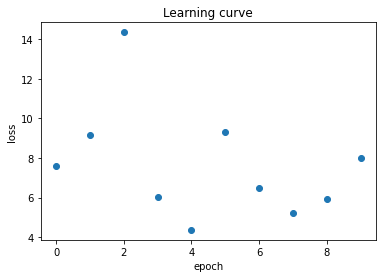

In [11]:
# learning curve
plt.scatter(x=loss_history.keys(),y=loss_history.values())
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve')

## 随机抽取测试

actual label: [9 3 1 2 9 1 2 9 3 0]
predict label: tensor([9, 3, 1, 6, 9, 1, 2, 9, 3, 0])


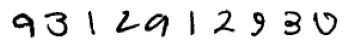

In [12]:
X=X_test[100:110]
y=y_test[100:110]
h=model.predict(X)
plot_digits(X)
print('actual label:',y)
print('predict label:',h)